In [10]:
# In [1]: Imports and Setup
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust path as needed
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import SNPE, simulate_for_sbi
from multiplex_sim import Microscope

In [2]:
# In [2]: Define the prior over emission peak (λ_max) and width (σ)
prior = sbi_utils.BoxUniform(low=torch.tensor([450.0, 10.0]), 
                             high=torch.tensor([650.0, 50.0]))

In [11]:

simulator = partial(
    Microscope.simulate_detected_signal,
    num_channels=3,
    center_wavelengths=[500.0, 550.0, 600.0],
    bandwidth=15.0
)

In [12]:
# In [3]: Wrap the simulator
simulator, prior = sbi_utils.user_input_checks.prepare_for_sbi(simulator, prior)

/tmp/ipykernel_1016940/1640293814.py:2: DeprecationWarning: This method is deprecated as of sbi version v0.23.0. and will be removed in a         future release.Please use `process_prior` and `process_simulator` in the future.
  simulator, prior = sbi_utils.user_input_checks.prepare_for_sbi(simulator, prior)


In [13]:
# In [4]: Generate training data via simulation
inference = sbi_inference.SNPE(prior)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 23810.57it/s]


 Neural network successfully converged after 254 epochs.

In [14]:
# Define true parameters for a fluorophore
true_params = torch.tensor([[545.0, 20.0]])  # shape: (1, 2)

# Define 3 narrow-band detection channels at these peak wavelengths:
center_wavelengths = [500.0, 550.0, 600.0]  # in nm
bandwidth = 15.0  # narrow filters

# Simulate the detected signal vector (1 value per channel)
x_observed = Microscope.simulate_detected_signal(
    params=true_params,
    num_channels=3,
    center_wavelengths=center_wavelengths,
    bandwidth=bandwidth
)

print(f"Simulated observations for {center_wavelengths} nm channels:")
print(x_observed)

Simulated observations for [500.0, 550.0, 600.0] nm channels:
tensor([[ 5.9527, 29.4839,  2.6747]])


In [16]:
print(posterior.posterior_estimator.condition_shape)
print(x_observed[0].shape)

torch.Size([3])
torch.Size([3])


In [17]:
# In [6]: Draw posterior samples conditioned on observed signal
samples = posterior.sample((10000,), x=x_observed[0])
samples_np = samples.numpy()

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 625800.70it/s]


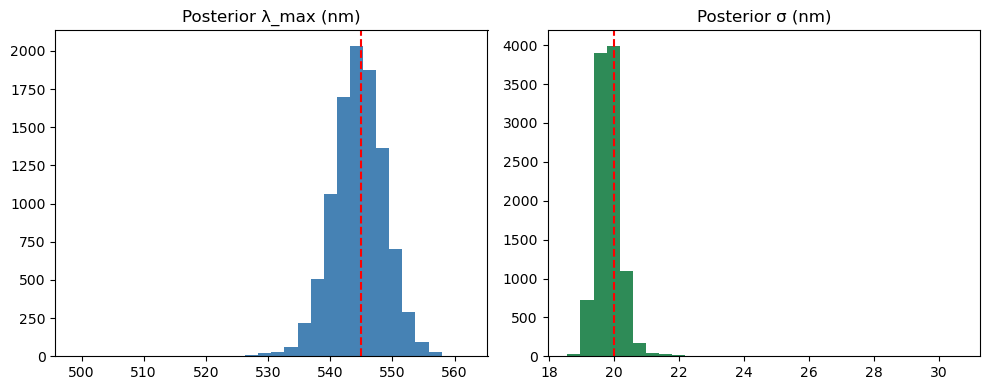

In [18]:
# In [7]: Plot posterior samples
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(samples_np[:, 0], bins=30, color='steelblue')
ax[0].axvline(true_params[0, 0], color='red', linestyle='--')
ax[0].set_title("Posterior λ_max (nm)")

ax[1].hist(samples_np[:, 1], bins=30, color='seagreen')
ax[1].axvline(true_params[0, 1], color='red', linestyle='--')
ax[1].set_title("Posterior σ (nm)")

plt.tight_layout()
plt.show()
